/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


step 1: elapsed 2.4771132469177246
step 2: elapsed 0.03176546096801758
step 3: elapsed 21.309473514556885
-------------------------------------------
Handle transitivity:
	Intra:		 2766
	Intra(choice):	 20
	Inter:		 22260
	Inter(choice):	 1609
-------------------------------------------
	Time =  99111  ms
	result: 0

	Total cost: 1761.7653366638665

# valid points:		 276
# invalid points:	 34
step 4: elapsed 99.21771383285522
step 5: elapsed 0.023904085159301758


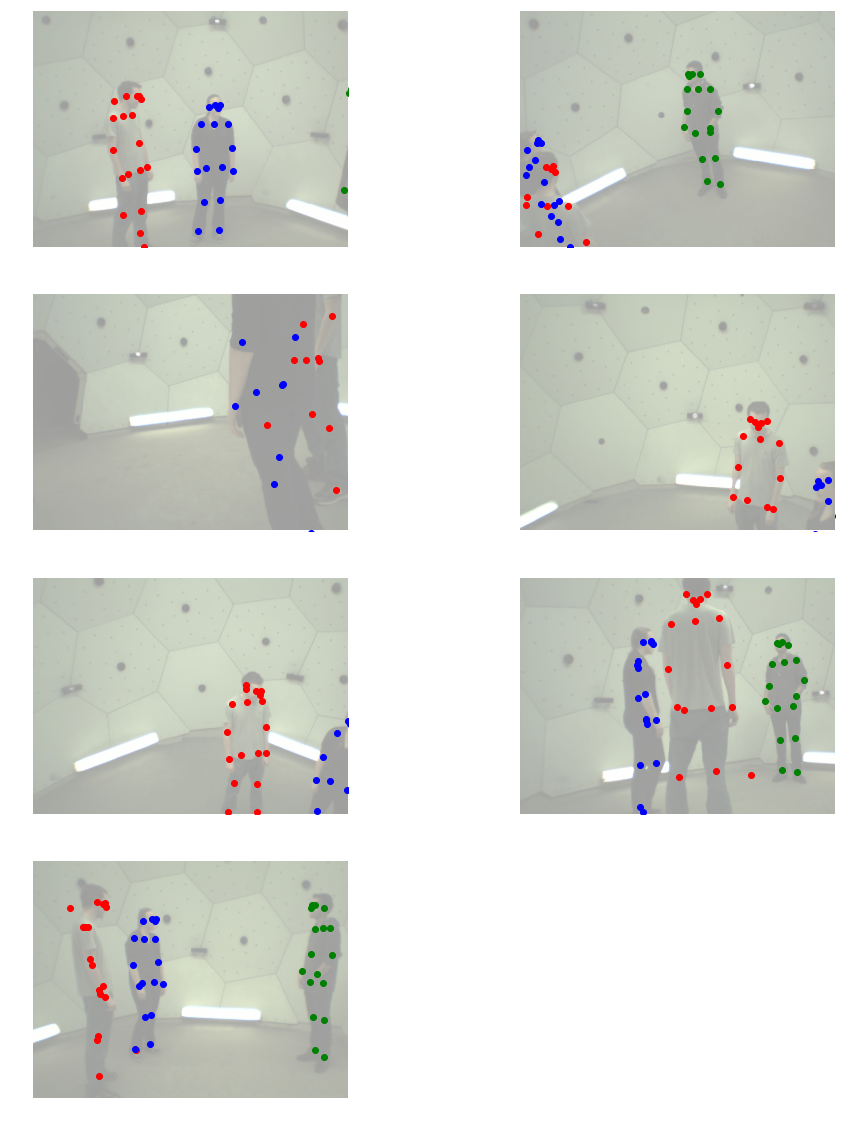

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs

from mvpose.data import cmu_panoptic

root = Settings['CMU']['data_root']
    
FRAME = 2000

panels = [1,  6, 10, 14, 15, 18, 5]
nodes = [ 1, 15,  6,  3, 12, 13, 8]

seq_name = '160422_ultimatum1'

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)


heatmaps, pafs = paf_loader.load_confidence_map_and_paf('cmu', Im, FRAME)


# ==================================
from mvpose import pose
from mvpose.algorithm import graphcut
from mvpose.data.default_limbs import DEFAULT_SENSIBLE_LIMB_LENGTH

graphcut_params = graphcut.get_parameters(
    radius=5, max_radius=30)
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                      sensible_limb_length=DEFAULT_SENSIBLE_LIMB_LENGTH/10,
                      graphcut_params=graphcut_params, debug=True)
# ==================================


from mvpose.algorithm.candidate_selection import project_human_to_2d


Humans = detections

fig = plt.figure(figsize=(16,20))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Debug.candidates2d.Calib_undistorted):
    ax = fig.add_subplot(4,2,1+idx)
    ax.axis('off')
    ax.set_xlim([0, 640])
    ax.set_ylim([480, 0])
    im = Im[idx]
    mapx, mapy = Debug.candidates2d.undistort_maps[idx]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[pid])
    
plt.show()